<h1> SNR Linear Regression on LISA data</h1> 

In the following, we are gonna use the Black holes data generated using the code at this [link](https://github.com/KuZa91/Generating-a-BH-Merging-Catalogue/blob/master/BHCatalogV4.1.ipynb), together with the estimated SNR on the LISA detector strain provided by Nikos Karnesis et. al. to try to fit a linear regression on the relation among parameters and SNR. 
Let's start by importing some modules !

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
import sklearn.utils as skut
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from multiprocessing import Pool, Manager, Value
from functools import partial
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<h2> Global Variables of the Simulation </h2>

The training data can be loaded using  :

In [2]:
df_key = 'SOBBH'
df_nm = 'TrainData.h5'
train_data = pd.read_hdf(df_nm, df_key)


the train data appear as follows.

In [3]:
train_data

,ChMs,DeltaM,distance,InBandT,Inclination,SNR_Ideal
0,4.729341,0.001592,2.133770,7000.599908,2.335913,0.01
1,5.005127,0.620365,2.673357,4232.634404,0.697830,0.01
2,4.734721,0.032402,2.839051,1971.592774,2.648983,0.01
3,5.153123,0.984108,2.673357,5392.216716,3.019648,0.01
4,6.552608,4.875557,2.308263,2772.749490,0.127102,0.02
...,...,...,...,...,...,...
34563219,86.480238,0.712735,2.624757,20.496509,1.691540,1.26
34563220,86.501391,0.573237,3.124760,4239.518523,0.966862,0.01
34563221,86.541524,0.542906,6.558404,596.432229,0.172599,0.06
34563222,86.586592,0.399863,3.698479,1704.064583,0.479717,0.03


We know from previous studies that the dependance on *inclination* of the SNR is non-linear, in particular, we know that this term damp off the value of SNR when close to $\pi / 2$.
We can hence start by redefining a new variable as the distance of the inclination to the latter :

In [4]:
d_inc = abs(train_data.Inclination - (np.pi/2.))

and define an inclination factor that maximize it's value for *d_inc = 0* as :

In [5]:
train_data['inc_fac'] = 1./(1. - np.exp(- d_inc))

What is left is a column with all ones in order to estimate the intercept of the linear regression, this can be done by recycling the previous list as :

In [6]:
d_inc[:] = 1.
train_data['Intercept'] = d_inc
d_inc = []

<h2> Separing the train data from the test data </h2>

As we are going to use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), let's start by shuffling our data in order to avoid having the same result on each run, and separe them in a set of _train data_ and one for the _test data_.

In [7]:
train_data = skut.shuffle(train_data)

In [8]:
train_data

,ChMs,DeltaM,distance,InBandT,Inclination,SNR_Ideal,inc_fac,Intercept
15336076,36.696724,6.217563,2.072817,3795.741148,0.974306,0.01,2.225887,1.0
7447548,8.233883,0.715399,2.525203,5310.318564,2.435619,0.01,1.727492,1.0
2056857,19.795325,12.816656,2.926052,980.710291,1.742272,0.01,6.346023,1.0
17319589,5.358954,0.175673,4.544162,10437.188047,0.600457,0.01,1.610188,1.0
1210654,5.747780,0.410206,1.319986,4570.062777,2.432819,0.02,1.731023,1.0
...,...,...,...,...,...,...,...,...
4647365,6.428012,0.558132,3.089384,1809.088267,0.615280,0.01,1.624995,1.0
11783909,19.951477,8.332299,1.560537,3220.642658,1.573284,0.01,402.487614,1.0
8953623,6.211496,0.413456,3.152120,2577.069698,3.102104,0.01,1.275921,1.0
25463673,7.591513,0.166809,5.622369,118.927481,2.851470,0.07,1.384754,1.0


We can now separe the data in training data and test data, we are gonna use _9/10_ of the original train data to train our model and the rest to cross validate :

In [9]:
train = train_data[0:int(len(train_data['Intercept'])*9/10)]
test = train_data[int(len(train_data['Intercept'])*9/10):]

so that our features and targets can be separed in the two arrays :

In [10]:
x_train = np.array([train.Intercept, 1./train.distance, train.ChMs**(5./2.), train.DeltaM, train.InBandT, train.inc_fac])
x_train = np.transpose(x_train)
y_train = np.array(train.SNR_Ideal)

we decided to use in the data the inverse of the _distance_ and the _chirp mass_ to the _5/2_ instead of the default values, because we already know the dependancy of _SNR_ on the latter from [literature](https://arxiv.org/abs/gr-qc/9701039).
In the same way, we can proceed for our test data obtaining :

In [11]:
x_test = np.array([test.Intercept, 1./test.distance, test.ChMs**(5./2.), test.DeltaM, test.InBandT, test.inc_fac])
x_test = np.transpose(x_test)
y_test = np.array(test.SNR_Ideal)

<h2> Estimating the coefficients of the Linear Regression </h2>

To estimate the coefficients of the linear regression, we can use the built-in function _np.linalf.lstsq_, we obtain the following results :

In [12]:
c = np.linalg.lstsq(x_train, y_train,rcond = None)[0]
print('We found the following coefficients to interpolate the data : ', c)

We found the following coefficients to interpolate the data :  [ 2.17686210e-02  4.78464311e-02  9.22453429e-07  3.14591928e-04
 -4.83497917e-06 -7.16611357e-09]


<h2> ML estimated SNR on test data </h2>

Given the coefficients of the linear regression, the _ML_ estimated SNR for the test data can be easily obtained as :

In [13]:
yml_test = x_test @ c
yml_test[yml_test < 0.] = 0.

in the same way, to estimate the error on the train data we can define :

In [14]:
yml_train = x_train @ c
yml_train[yml_train < 0.] = 0.

<h2> Valutation of the performance - Train Data</h2>

In order to estimate the efficiency of the approximation, we need to compare the values of the _SNR_ estimated using the linear regression to the ones known for our train data, let's start by estimating the difference from the real value as:

In [15]:
y_err = abs(y_train - yml_train)
print('The average of the error between ML estimation and real train data targets is : ', np.average(y_err))

The average of the error between ML estimation and real train data targets is :  0.016973224669077663


We can observe how the error is distributed in function of the SNR to be predicted as : 

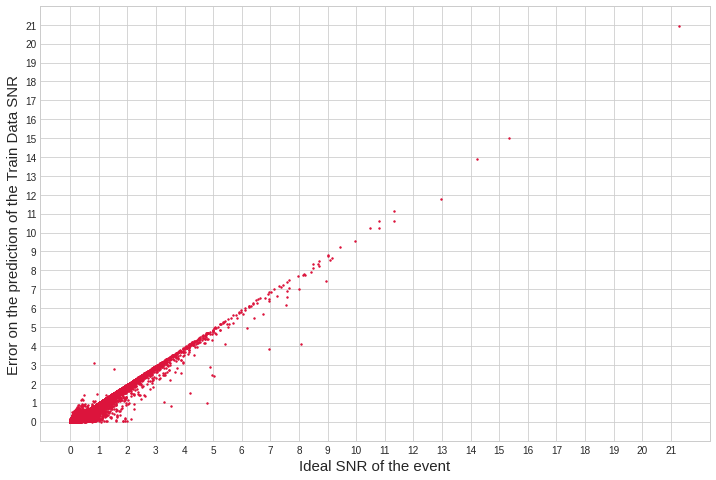

In [16]:
#Automatically setting the ticks

Nxtick = int((max(y_train)- min(y_train))/12)
if Nxtick == 0:
    Nxtick = 1
    
Nytick = int((max(y_err)- min(y_err))/12)
if Nytick == 0:
    Nytick = 1

plt.figure(figsize=(12,8))
plt.scatter(y_train, y_err, s=2, color = 'crimson')
plt.xlabel('Ideal SNR of the event', fontsize = 15)
plt.xticks(np.arange(min(np.around(y_train)), max(np.around(y_train)+1), Nxtick))
plt.ylabel('Error on the prediction of the Train Data SNR', fontsize = 15)
plt.yticks(np.arange(min(y_err), max(y_err)+1, Nytick ))
plt.savefig('TrainPredictionError.png',dpi=500)

In the same way, we can predict the percentual error as :

In [17]:
y_perr = 100.*abs(y_train - yml_train)/y_train
print('The average of the percentual error from the ML estimation to the real value is : ', np.average(y_perr))

The average of the percentual error from the ML estimation to the real value is :  92.54017909105782


which gives the following scatterplot for the distribution of the errors :

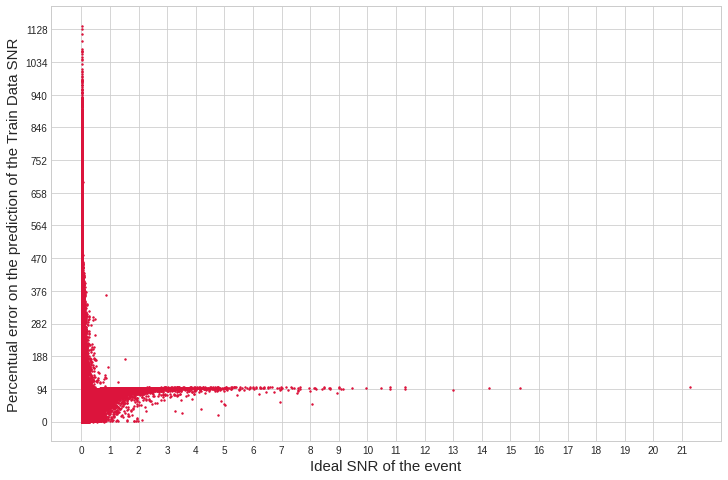

In [18]:
#Automatically setting the ticks

Nxtick = int((max(y_train)- min(y_train))/12)
if Nxtick == 0:
    Nxtick = 1
    
Nytick = int((max(y_perr)- min(y_perr))/12)
if Nytick == 0:
    Nytick = 1    

plt.figure(figsize=(12,8))
plt.scatter(y_train, y_perr, s=2, color = 'crimson')
plt.xlabel('Ideal SNR of the event', fontsize = 15)
plt.xticks(np.arange(min(np.around(y_train)), max(np.around(y_train)+1), Nxtick))
plt.ylabel('Percentual error on the prediction of the Train Data SNR', fontsize = 15)
plt.yticks(np.arange(min(y_perr), max(y_perr)+1, Nytick))
plt.savefig('TrainPercentualPredictionError.png',dpi=500)

<h2> Valutation of the performance - Test Data</h2>

In the same way, to understand how well our approximation can predict new data, we need to compare the values of the _SNR_ estimated using the linear regression to the ones known for our test data, let's start by estimating the difference from the real value as:

In [19]:
y_err = abs(y_test - yml_test)
print('The average of the error from the ML estimation to the real value is : ', np.average(y_err))

The average of the error from the ML estimation to the real value is :  0.016983808560658942


We can observe how the error is distributed in function of the SNR to be predicted as : 

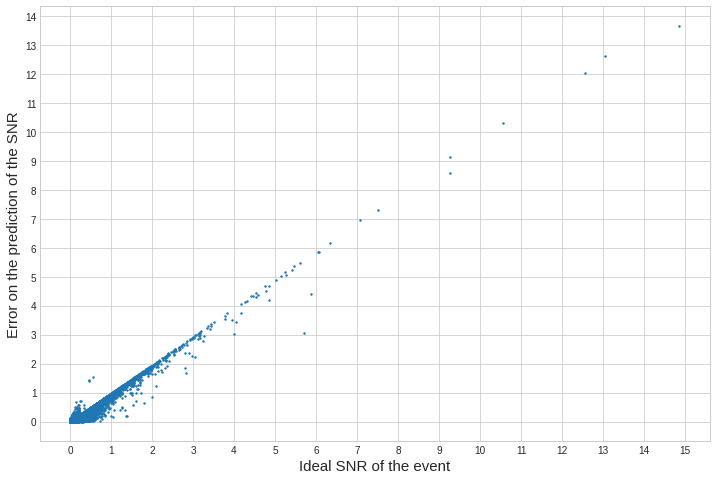

In [20]:
#Automatically setting the ticks

Nxtick = int((max(y_test)- min(y_test))/12)
if Nxtick == 0:
    Nxtick = 1
    
Nytick = int((max(y_err)- min(y_err))/12)
if Nytick == 0:
    Nytick = 1

plt.figure(figsize=(12,8))
plt.scatter(y_test, y_err, s=2)
plt.xlabel('Ideal SNR of the event', fontsize = 15)
plt.xticks(np.arange(min(np.around(y_test)), max(np.around(y_test)+1), Nxtick))
plt.ylabel('Error on the prediction of the SNR', fontsize = 15)
plt.yticks(np.arange(min(y_err), max(y_err)+1, Nytick ))
plt.savefig('TestPredictionError.png',dpi=500)

In the same way, we can predict the percentual error as :

In [21]:
y_perr = 100.*abs(y_test - yml_test)/y_test
print('The average of the percentual error from the ML estimation to the real value is : ', np.average(y_perr))

The average of the percentual error from the ML estimation to the real value is :  92.4750940722762


which gives the following scatterplot for the distribution of the errors :

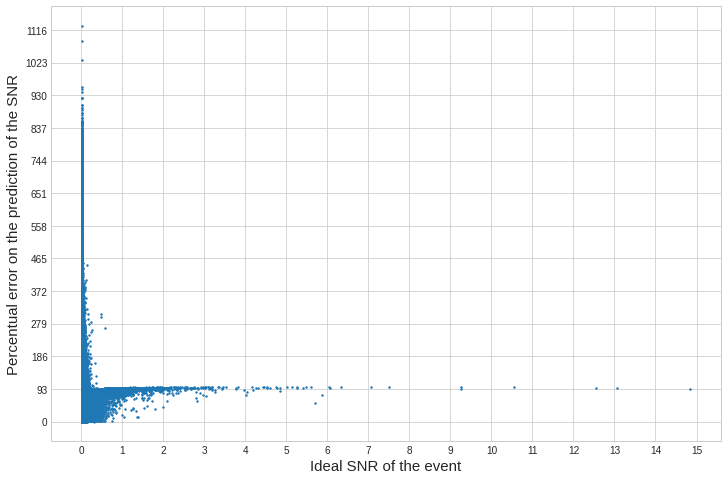

In [22]:
#Automatically setting the ticks

Nxtick = int((max(y_test)- min(y_test))/12)
if Nxtick == 0:
    Nxtick = 1
    
Nytick = int((max(y_perr)- min(y_perr))/12)
if Nytick == 0:
    Nytick = 1    

plt.figure(figsize=(12,8))
plt.scatter(y_test, y_perr, s=2)
plt.xlabel('Ideal SNR of the event', fontsize = 15)
plt.xticks(np.arange(min(np.around(y_test)), max(np.around(y_test)+1), Nxtick))
plt.ylabel('Percentual error on the prediction of the SNR', fontsize = 15)
plt.yticks(np.arange(min(y_perr), max(y_perr)+1, Nytick))
plt.savefig('TestPercentualPredictionError.png',dpi=500)